# 1. 项目介绍
数据集包含欧洲持卡人于2013年9月通过信用卡进行的交易。
该数据集提供两天内发生的交易，其中在284,807笔交易中有492起欺诈行为。
**数据集非常不平衡，负面类别（欺诈）占所有交易的0.172％。**

数据集只包含数值输入变量，这是PCA变换的结果。
遗憾的是，由于保密问题，我们无法提供有关数据的原始特征和更多背景信息。
特征V1，V2，... V28是经过PCA转换的，**唯一没有用PCA转换的特征是'Time'和'Amount'。**

- 'Time'包含每个交易与数据集中第一个交易之间经过的秒数。
- 'Amount'是交易金额
- 'Class'是标签，在欺诈的情况下其值为1，否则为0。

## 1.1 目标
- 理解提供给我们的“少量”数据的少量分布。
- 创建“欺诈”和“非欺诈”交易的子数据集，比率为50/50。
- 确定我们要使用的分类器，并确定哪个具有更高的精度。
- 理解由不平衡数据集造成的常见错误。

# 2. 大纲

总体布局：
1. 项目介绍
2. 大纲
3. 了解数据
4. 数据缩放及查看数据分布
5. 划分原始数据集
6. 交叉验证之前的随机欠采样（没有使用任何算法直接进行欠采样）
7. 查看数据集平衡后特征的分布以及特征与标签的相关性
8. 异常值检测
9. 降维和聚类（验证算法有效性）
10. 欠采样下的分类（NearMiss算法）
11. 深入研究逻辑回归
12. 使用 SMOTE 算法进行过采样
13. 使用测试集测试逻辑回归模型的效果


## 2.1 纠正以前关于不平衡数据集的错误想法
- 不要在过采样或者欠采样的数据集上进行测试。
- 如果我们想实现交叉验证，请记住**在交叉验证期间(而不是在此之前)对训练数据进行过采样或欠采样!**
- 在不平衡的数据集上不要使用准确度作为度量(准确度通常会很高而且会误导)，而是**使用f1-score, precision/recall score或confusion matrix。**

# 3. 了解数据
- 我们必须做的第一件事是对数据有个基本的了解。记住，除了交易transaction和金额amount这两列，我们不知道其他列是什么(出于隐私原因)。
我们唯一知道的是，那些未知的列已经被缩放了。


## 3.1 摘要
- 交易金额'amount'相对较小。平均交易金额接近88美元。
- 没有“Null”值，所以不需要考虑缺失值。
- 正常交易的样本占比为99.83%，欺诈样本占比为0.17%，数据集严重不平衡。


## 3.2 使用的特征技术
- PCA Transformation：数据的描述是所有的特征都经过PCA变换(降维技术)(除了时间time和金额amount)。
- Scaling:为了使用PCA转换特征，需要事先对特征进行缩放。(在本例中，所有的V特征都被缩放了)

In [1]:
# 导入相应的包
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.patches as mpatches
import time

# 分类器
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

# 其他包
from sklearn.preprocessing import StandardScaler, RobustScaler
from scipy.stats import norm
from sklearn.model_selection import RandomizedSearchCV, cross_val_predict, GridSearchCV, learning_curve, ShuffleSplit, cross_val_score, StratifiedKFold, train_test_split
from imblearn.under_sampling import NearMiss
from collections import Counter
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve, average_precision_score, roc_auc_score, precision_score, recall_score, f1_score, accuracy_score, classification_report
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings("ignore")

In [2]:
# 导入数据
df = pd.read_csv('./creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
#查看描述性统计分析: Amount 和 Time 没有缩放
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.918649e-15,5.682686e-16,-8.761736e-15,2.811118e-15,-1.552103e-15,2.040130e-15,-1.698953e-15,-1.893285e-16,-3.147640e-15,...,1.473120e-16,8.042109e-16,5.282512e-16,4.456271e-15,1.426896e-15,1.701640e-15,-3.662252e-16,-1.217809e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [4]:
# 查看是否有缺失值,在这里是没有缺失值的，所以不用考虑缺失值
df.isnull().sum().max()

0

In [5]:
#查看列名
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [6]:
# 数据集严重不平衡，需解决这个问题。
print("No Frauds", round(df['Class'].value_counts()[0] / len(df) * 100, 2), '% of the dataset')
print("Frauds", round(df['Class'].value_counts()[1] / len(df) * 100, 2), '% of the dataset')

No Frauds 99.83 % of the dataset
Frauds 0.17 % of the dataset


Text(0.5, 1.0, 'Class Distributions \n (0: No Fraud || 1: Fraud)')

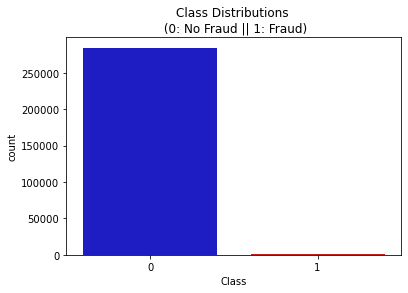

In [7]:
#对标签进行画图，直观地表示正负类比例
colors = ["#0101DF", "#DF0101"]

sns.countplot('Class', data = df, palette = colors)
plt.title("Class Distributions \n (0: No Fraud || 1: Fraud)")

根据上图：
- 注意我们的原始数据集是很不平衡的。大部分交易是非欺诈的。
- 如果我们使用这个数据集作为我们预测模型和分析的基础，我们可能会得到很多错误，模型也可能会过拟合，因为这个数据集会使模型假定大多数交易是非欺诈的。
- 但我们不想模型进行这样的假定，而是想检测出欺诈的规律。

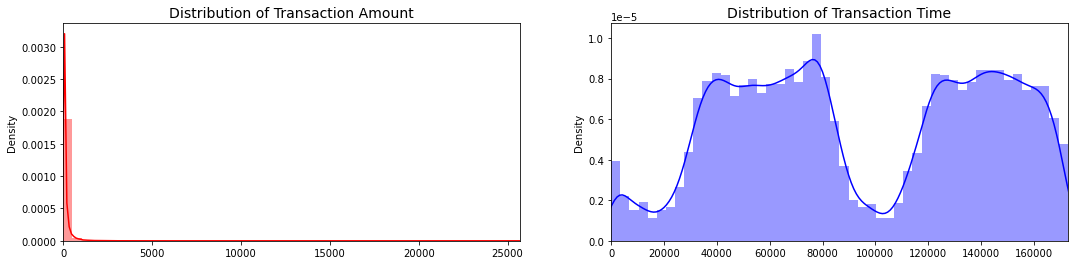

In [8]:
#对金额Amount,时间Time进行画图
fig,ax = plt.subplots(1, 2, figsize = (18, 4))

amount_val = df['Amount'].values
time_val = df['Time'].values

sns.distplot(amount_val, ax = ax[0], color = 'r')
ax[0].set_title('Distribution of Transaction Amount', fontsize=14)
ax[0].set_xlim([min(amount_val), max(amount_val)])

sns.distplot(time_val, ax=ax[1], color='b')
ax[1].set_title('Distribution of Transaction Time', fontsize=14)
ax[1].set_xlim([min(time_val), max(time_val)])


plt.show()

- 通过图像我们可以进一步的观察出特征的分布是有多偏的，有一些技术将会减少偏斜的程度，这将会在后面实现。

# 4. 数据缩放及查看数据分布
- 在这个阶段，我们将首先缩放由时间'time'和金额'amount'组成的列。时间和金额应该像其他列一样缩放。
- 另一方面，我们还需要创建dataframe的子数据集，以便有等量的欺诈和非欺诈案例，帮助我们的算法更好地理解确定交易是否是欺诈的模式。


## 4.1 关于子数据集
- 子数据集其实就是一个正负样本比例为50/50，也就是说欺诈样本和非欺诈样本数量相同的数据集。


## 4.2 创建子数据集的理由
- 在上面的分析中已经看到原始数据集是高度不平衡的，如果使用原始数据集就会导致以下的问题：
    - 过拟合。我们的模型会假定大部分情况下都是非欺诈的，对于我们的模型，我们相要确定的是何时发生了欺诈。
    - 错误的相关性。 尽管我们不知道"V"特征代表了什么，但是如果我们能够知道每个特征对结果(欺诈或非欺诈)的影响还是很有用的，然而在不平衡的数据集上我们无法得知标签和特征的正确关联。
- 因此：
    - 对时间和金额这两列进行缩放。
    - 有492个欺诈样本所以我们可以随机获得492个非欺诈样本来组成新的子数据集。
    - 将492个欺诈样本和非欺诈样本进行合并，组成新的子数据集。

In [9]:
df.shape

(284807, 31)

In [10]:
# 对 Time 和 Amount 列进行缩放
# StandardScaler函数用于标准化数据，使数据每一个特征的均值为0，方差为1。也就是说，该函数用于使数据的分布变成标准正态分布。
std_scaler = StandardScaler()
#  RobustScaler 函数使用对异常值鲁棒的统计信息来缩放特征。这个标量去除中值，并根据分位数范围(默认为IQR即四分位数范围)对数据进行缩放。
#  IQR是第1个四分位数(第25分位数)和第3个四分位数(第75分位数)之间的范围。通过计算训练集中样本的相关统计量，对每个特征分别进行定心和缩放。然后将中值和四分位范围存储起来，使用“变换”方法用于以后的数据。
rob_scaler = RobustScaler()

# #reshape(-1,1)表示转换成1行
df['scaled_amount'] = rob_scaler.fit_transform(df['Amount'].values.reshape(-1, 1))
df['scaled_time'] = rob_scaler.fit_transform(df['Time'].values.reshape(-1, 1))

df.drop(['Time', 'Amount'], axis=1, inplace=True)

In [11]:
# 这里只是为了将缩放的两列放到第一第二列，便于观察
scaled_amount = df['scaled_amount']
scaled_time = df['scaled_time']

df.drop(['scaled_amount', 'scaled_time'], axis=1, inplace=True)
df.insert(0, 'scaled_amount', scaled_amount)
df.insert(1, 'scaled_time', scaled_time)

df.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,1.783274,-0.994983,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0
1,-0.269825,-0.994983,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0
2,4.983721,-0.994972,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0
3,1.418291,-0.994972,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0
4,0.670579,-0.994960,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0


# 5. 划分原始数据集

- 在进行欠采样之前，我们必须将原始数据集分割成训练集和测试集，因为我们**最后进行测试是在原始的测试集上进行测试，而不是在欠采样或者过采样后所创建的测试集上测试。**
- 我们的主要目的是用过采样或者欠采样后的数据去训练模型，然后在原始数据的测试集上进行测试。

In [12]:
print('No Frauds', round(df['Class'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Frauds', round(df['Class'].value_counts()[1]/len(df) * 100,2), '% of the dataset')

# 划分特征和标签
X = df.drop('Class', axis=1)
y = df['Class']

# StratifiedKFold则是在KFold的基础上，加入了分层抽样的思想，使得测试集和训练集有相同的数据分布。
# 因此表现在算法上，StratifiedKFold需要同时输入数据和标签，便于统一训练集和测试集的分布。
sss = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

for train_index, test_index in sss.split(X, y):
    print("Train:", train_index, "Test:", test_index)
    original_Xtrain, original_Xtest = X.iloc[train_index], X.iloc[test_index]
    original_ytrain, original_ytest = y.iloc[train_index], y.iloc[test_index]

# 转化为 array 类型数据
original_Xtrain = original_Xtrain.values
original_Xtest = original_Xtest.values
original_ytrain = original_ytrain.values
original_ytest = original_ytest.values

# 检查划分后数据集的结构，确保训练集、测试集中的X、y的数量一一对应
# np.unique() 函数 去除其中重复的元素 ，并按元素 由小到大 返回一个新的无元素重复的元组或者列表。
# return_counts：如果为 true，返回去重数组中的元素在原数组中的出现次数。
# 以下 ..._unique_label 结果为0和1；..._counts_label 中为0和1的数量。
train_unique_label, train_counts_label = np.unique(original_ytrain, return_counts=True)
test_unique_label, test_counts_label = np.unique(original_ytest, return_counts=True)
print('-' * 100)

print('Label Distributions: \n')
print(train_counts_label / len(original_ytrain))
print(test_counts_label/ len(original_ytest))

No Frauds 99.83 % of the dataset
Frauds 0.17 % of the dataset
Train: [ 30473  30496  31002 ... 284804 284805 284806] Test: [    0     1     2 ... 57017 57018 57019]
Train: [     0      1      2 ... 284804 284805 284806] Test: [ 30473  30496  31002 ... 113964 113965 113966]
Train: [     0      1      2 ... 284804 284805 284806] Test: [ 81609  82400  83053 ... 170946 170947 170948]
Train: [     0      1      2 ... 284804 284805 284806] Test: [150654 150660 150661 ... 227866 227867 227868]
Train: [     0      1      2 ... 227866 227867 227868] Test: [212516 212644 213092 ... 284804 284805 284806]
----------------------------------------------------------------------------------------------------
Label Distributions: 

[0.99827076 0.00172924]
[0.99827952 0.00172048]


# 6. 交叉验证之前的随机欠采样（没有使用任何算法直接进行欠采样）

- 在该项目的这个阶段，我们将使用随机欠采样，这将包括删除数据以获得一个平衡的数据集从而避免模型过拟合。
- 步骤：
    - 1.我们要做的第一件事是确定数据的不平衡程度(使用value_counts()去确定每个标签的数量)。
    - 2.一旦我们确定有多少欺诈交易(Fraud=1)，我们需要使得正常交易的数量和欺诈交易的数量是一样的(假设我们想要50/50比率)，也就是说有492个欺诈交易和492个正常交易。
    - 3.在使用了欠采样之后，我们会得到一个比率为50/50的子集，我们下一步要做的就是shuffle the data(打乱数据) ，看看每次运行我们的模型时是不是保持一定的准确性。

In [13]:
#由于标签是高度不平衡的，所以我们要使得标签是平衡的以便获得标签的正态分布

# 在创建子数据集之前打乱数据
# df.sample(frac=1) 这样对可以对df进行shuffle。其中参数frac是要返回的比例，比如df中有10行数据，我只想返回其中的30%,那么frac=0.3。
# 有时候，我们可能需要打混后数据集的index（索引）还是按照正常的排序。我们只需要这样操作： df.sample(frac=1).reset_index(drop=True)
df = df.sample(frac = 1)

# 欺诈交易的样本数量为492条
fraud_df = df.loc[df['Class'] == 1]
non_fraud_df = df.loc[df['Class'] == 0][:492]

normal_distributed_df = pd.concat([fraud_df, non_fraud_df])

# 对子数据集进行打乱
new_df = normal_distributed_df.sample(frac=1, random_state=42)

new_df.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
54553,0.547754,-0.448666,1.149589,-0.518091,0.642118,-0.106700,-0.522537,0.645862,-0.628543,0.193071,...,0.154149,-0.213187,-0.444354,-0.137479,-0.728002,0.282465,0.988047,-0.041162,0.004010,0
14338,-0.254873,-0.696272,1.125336,1.130146,-0.962975,2.675688,0.990075,-0.243318,0.316192,0.122960,...,-0.138814,-0.166737,-0.521934,-0.112376,-0.592077,0.520791,0.043354,0.015159,0.063612,1
142396,0.143506,-0.000059,-0.537152,1.072182,1.316695,1.123155,0.185313,0.105776,0.790742,-0.081411,...,-0.079131,0.056192,0.379248,-0.115989,0.117478,-0.280746,-0.345392,-0.047852,0.152489,0
123238,-0.293440,-0.092048,1.140208,1.156431,-1.471578,2.076278,0.774809,-1.002532,0.264948,0.013162,...,-0.125097,-0.387895,-0.866812,-0.121583,-0.356109,0.634573,-0.306311,0.094087,0.121065,1
15225,1.089779,-0.682656,-19.856322,12.095893,-22.464083,6.115541,-15.148022,-4.346724,-15.648507,13.276805,...,1.582930,1.750730,-1.409636,-0.809809,0.121397,1.350300,-0.224292,1.597621,0.476920,1


- 随机欠抽样所面临的主要问题是：由于面临大量的数据损失(从284315个非欺诈交易里产生492个非欺诈交易)，所以分类模型可能不会像我们希望的那样准确。

# 7. 查看数据集平衡后特征的分布以及特征与标签的相关性
- 我们已经得到了处理后的平衡数据集 new_df，现在我们可以更进一步数据分析和数据预处理了！

子数据集的标签分布
0    0.5
1    0.5
Name: Class, dtype: float64


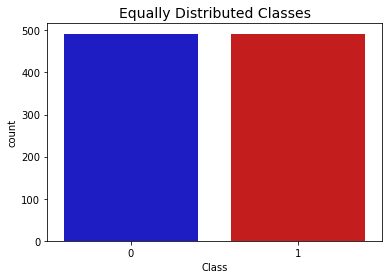

In [14]:
print('子数据集的标签分布')
print(new_df['Class'].value_counts() / len(new_df))

# 画图表示  1:1
sns.countplot('Class', data=new_df, palette=colors)
plt.title('Equally Distributed Classes', fontsize=14)
plt.show()

## 7.1 相关性矩阵（Correlation Matrices）
- 相关性矩阵是我们理解数据的关键，我们想要知道某些特征是不是很大程度上影响某些特定的交易是欺诈。
然而选择正确的dataframe(子集)，是很重要的，这样我们才能知道某些特征和欺诈交易是不是存在着高度的正相关或负相关。


## 7.2 摘要
- 负相关：V17, V14, V12, V10; 即这些数值越低，越有可能是一个欺诈交易样本。
- 正相关：V2, V4, V11, V19; 即这些数值越高，越有可能是一个欺诈交易样本。
- 箱型图：绘制箱型图，查看特征值与Class之间的关系。

- 注意：
    - 在进行相关性分析时，使用随机欠采样后的子集。不要使用原始数据。
    - 这是因为原始数据样本分布不均衡，不能正确的显示特征值与目标值之间的相关性。

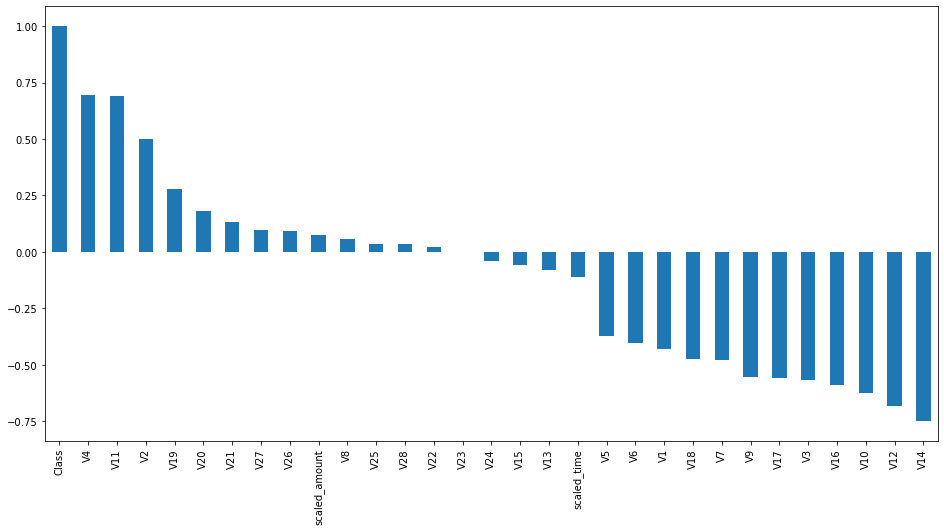

In [15]:
# 通过柱形图查看关联关系
plt.figure(figsize = (16, 8))
new_df.corr()['Class'].sort_values(ascending=False).plot(kind = 'bar')

# facecolor='w' , 存储图片的背景是白色的
#plt.savefig("通过柱形图查看关联关系.png", bbox_inches='tight', dpi=300, facecolor='w')
plt.show()

Text(0.5, 1.0, 'SubSample Correlation Matrix \n (use for reference)')

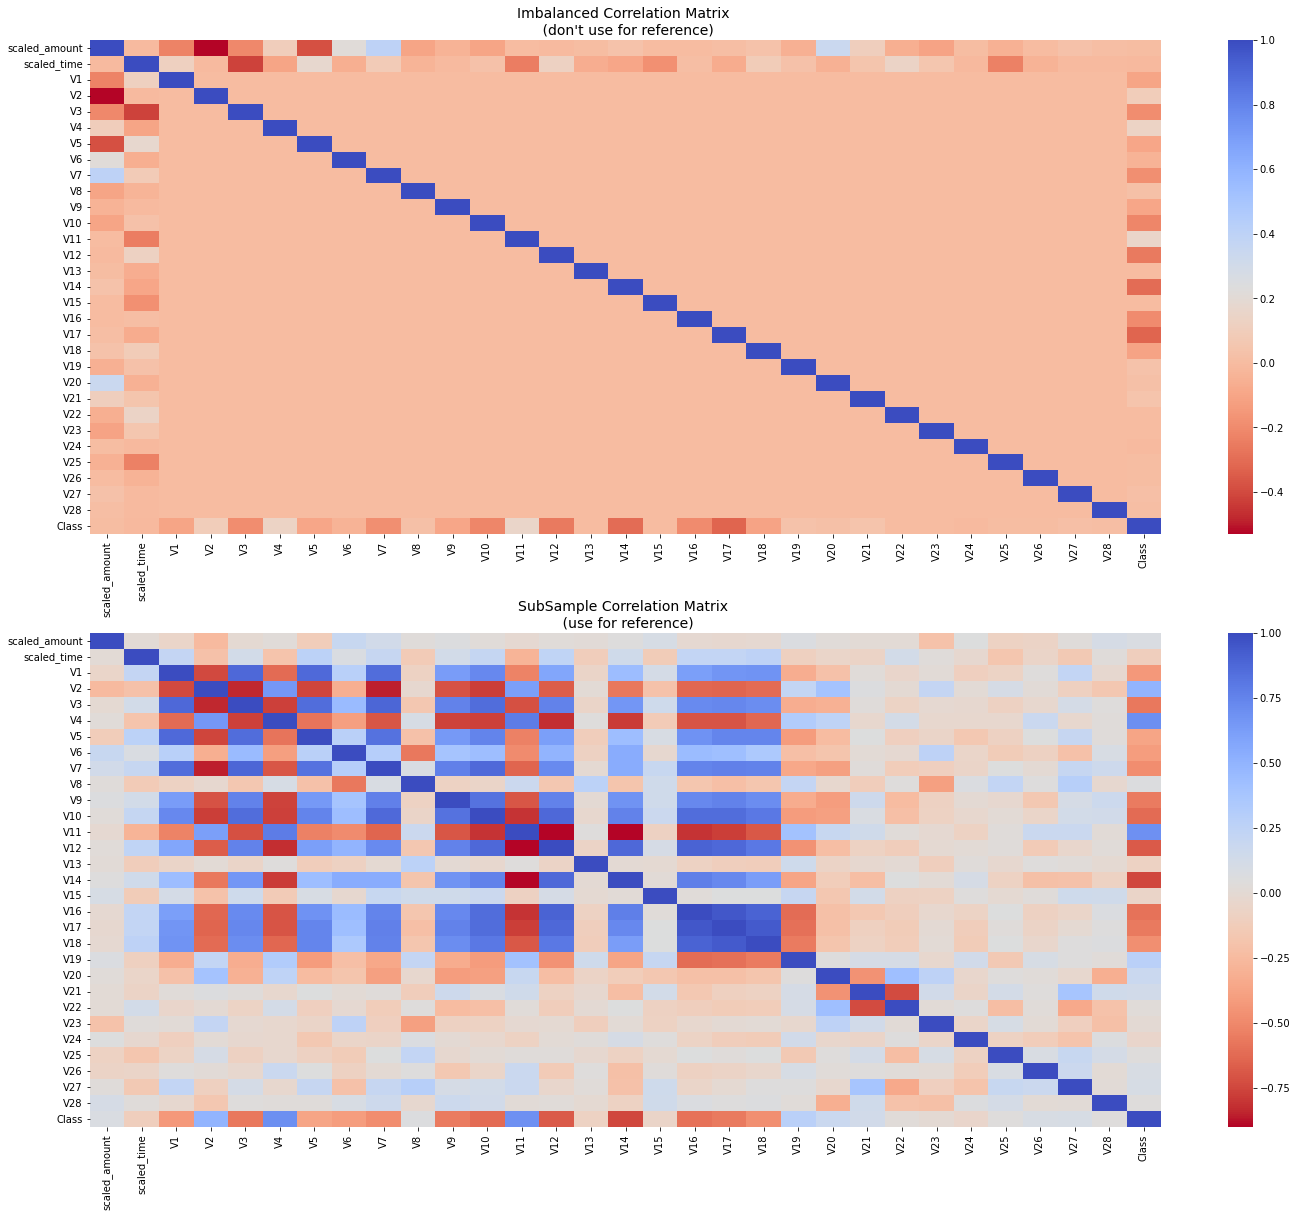

In [16]:
#创建热图查看原始的不平衡数据集和平衡的子数据集的相关性，进行对比

# 确保使用随机欠采样后的数据进行相关性分析！
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(24, 20))

# 原始数据制作的热图，不要使用，只是为了对比！
corr = df.corr()
sns.heatmap(corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax1)
ax1.set_title("Imbalanced Correlation Matrix \n (don't use for reference)", fontsize=14)

# 子数据集制作的热图，正确的打开方式！
sub_sample_corr = new_df.corr()
sns.heatmap(sub_sample_corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax2)
ax2.set_title('SubSample Correlation Matrix \n (use for reference)', fontsize=14)

根据上图：
- 相差很大。因为原始数据样本的不均衡，特征值与目标值之间的相关性没有很好的体现出来。
- 这就是为什么要用子数据集进行分相关性分析。

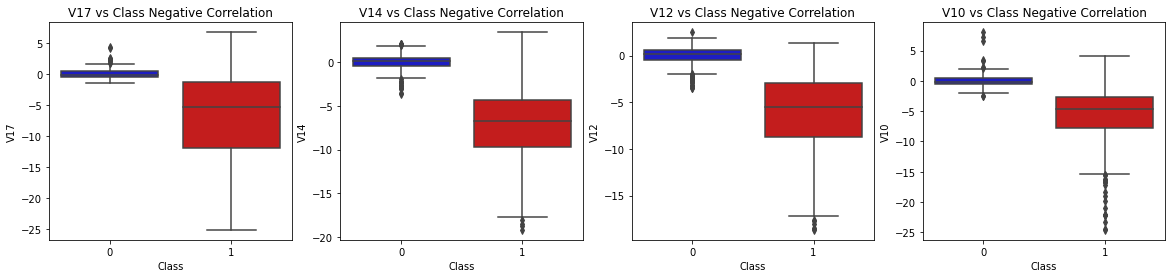

In [17]:
# 对负相关的特征绘制箱线图，便于更好理解特征； V17, V14, V12, V10
f, axes = plt.subplots(ncols=4, figsize=(20,4))

sns.boxplot(x='Class', y='V17', data=new_df, palette=colors, ax=axes[0])
axes[0].set_title('V17 vs Class Negative Correlation')

sns.boxplot(x="Class", y="V14", data=new_df, palette=colors, ax=axes[1])
axes[1].set_title('V14 vs Class Negative Correlation')


sns.boxplot(x="Class", y="V12", data=new_df, palette=colors, ax=axes[2])
axes[2].set_title('V12 vs Class Negative Correlation')


sns.boxplot(x="Class", y="V10", data=new_df, palette=colors, ax=axes[3])
axes[3].set_title('V10 vs Class Negative Correlation')

plt.show()

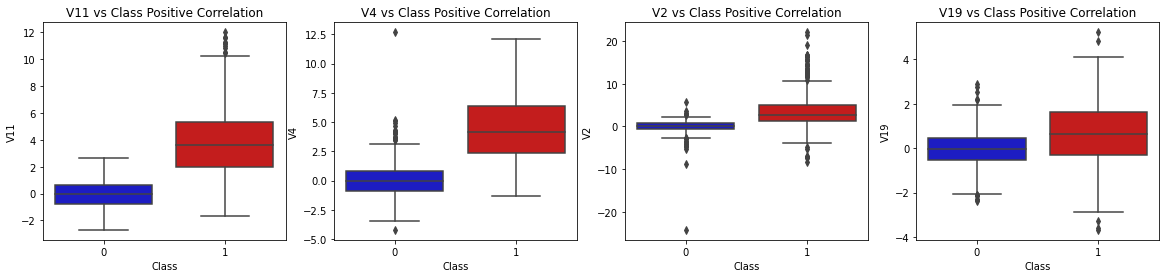

In [18]:
# 对正相关的特征绘制箱线图，便于更好理解特征； V2, V4, V11, V19
f, axes = plt.subplots(ncols=4, figsize=(20,4))

sns.boxplot(x="Class", y="V11", data=new_df, palette=colors, ax=axes[0])
axes[0].set_title('V11 vs Class Positive Correlation')

sns.boxplot(x="Class", y="V4", data=new_df, palette=colors, ax=axes[1])
axes[1].set_title('V4 vs Class Positive Correlation')


sns.boxplot(x="Class", y="V2", data=new_df, palette=colors, ax=axes[2])
axes[2].set_title('V2 vs Class Positive Correlation')


sns.boxplot(x="Class", y="V19", data=new_df, palette=colors, ax=axes[3])
axes[3].set_title('V19 vs Class Positive Correlation')

plt.show()

# 8. 异常值检测

- 这一节主要的目的就是从与标签高度相关的特征中删除极端异常值，这会对我们的模型准确率产生积极的影响

## 8.1 四分位数方法
- Interquartile Range(IQR):我们计算75%分位数和25%分位数的差值，我们的目标是创建一个超过75百分位数和25百分位数的阈值，当样本值超过这个阈值这个样本就会被删除。
- Boxplots：除了很容易看到25百分位数和75百分位数之外，也很容易看到极端的异常值(点在上界或者下界之外)。
- IQR（Interquartile Range，四分位距）：
    - 四分位距 (IQR) 是一种衡量变异性的方法，它通过将数据集划分为四分位数来实现。
    - 四分位数将一个按等级排序的数据集划分为四个相等的部分。即 Q1（第1个四分位数）、Q2（第2个四分位数）和 Q3（第3个四分位数）。
    - IQR 定义为 Q3–Q1，工程上经验是：位于 Q3+1.5*IQR 或 Q1-1.5*IQR 之外的数据被视为离群值。

## 8.2 如何计算四分位数

计算四分位数需要先将数据按照从小到大的顺序排列，然后按照以下步骤进行计算：

1、计算第一四分位数（Q1），即数据的25%分位数。

- 如果样本容量（n）是奇数，则Q1为第（n+1）/4个数据的值。

- 如果样本容量（n）是偶数，则Q1为第n/4个数据与第（n/4+1）个数据的平均值。

2、计算第三四分位数（Q3），即数据的75%分位数。

- 如果样本容量（n）是奇数，则Q3为第（3n+1）/4个数据的值。

- 如果样本容量（n）是偶数，则Q3为第3n/4个数据与第（3n/4+1）个数据的平均值。

3、计算四分位距（IQR），即数据的上四分位数与下四分位数之差，即IQR=Q3-Q1。

- 四分位数可以帮助我们更好地了解数据的分布情况，特别是在面对异常值时，四分位数比平均数更加稳健。


## 8.3 异常值删除的权衡
- 我们必须小心地定义去除异常值的阈值。我们通过将一个数字(例如:1.5)乘以(四分位数范围)来确定阈值。
这个阈值越高，检测到的异常值就越少(乘以一个更高的数，例如:3)，而这个阈值越低，检测到的异常值就越多。
- The Tradeoff
    - 阈值越低，它将删除的异常值就越多，但是，**我们希望更多地关注“极端异常值”，而不仅仅是异常值。**
    - 为什么?因为我们可能会有信息丢失的风险，这将导致我们的模型有较低的准确性。

## 8.4 摘要
步骤：
- 特征值分布可视化。先绘制想要清除异常值的特征值的分布图。**与V12、V10相比，V14是唯一体现高斯分布的特征值。**
- 确定阈值。当我们决定用哪个数字（1.5-3）乘以iqr之后，上限由q75+阈值决定，下限由q25-阈值决定。
- 清除极端异常值。我们创建一个条件删除，声明如果在两个极端都超过“阈值”，实例将被删除。
- 箱型图：通过绘制箱型图来查看。可以看出，“极端异常值”的数量会减少到一定程度。

注意：
- 通过清除极端异常值后，模型评估分数提升了3%。异常值影响了模型准确性，在清除异常值时，也要注意信息丢失风险，因为这会导致模型欠拟合。

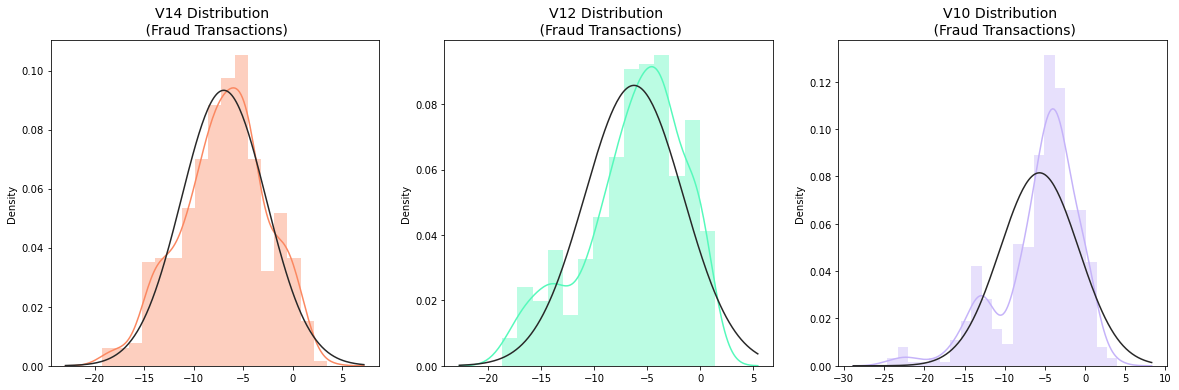

In [19]:
# V14, V12, V10 是负相关性最大的前三个特征值，先拿他们开刀！
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

v14_fraud_dist = new_df['V14'].loc[new_df['Class'] == 1].values
sns.distplot(v14_fraud_dist, ax=ax1, fit=norm, color='#FB8861')
ax1.set_title('V14 Distribution \n (Fraud Transactions)', fontsize=14)

v12_fraud_dist = new_df['V12'].loc[new_df['Class'] == 1].values
sns.distplot(v12_fraud_dist,ax=ax2, fit=norm, color='#56F9BB')
ax2.set_title('V12 Distribution \n (Fraud Transactions)', fontsize=14)


v10_fraud_dist = new_df['V10'].loc[new_df['Class'] == 1].values
sns.distplot(v10_fraud_dist,ax=ax3, fit=norm, color='#C5B3F9')
ax3.set_title('V10 Distribution \n (Fraud Transactions)', fontsize=14)

plt.show()

- 删除异常值。

In [20]:
# 1、清除 V14 的异常值（V14 特征值是与欺诈样本负相关性最大的特征值，先拿它动手！）
v14_fraud = new_df['V14'].loc[new_df['Class'] == 1].values
q25, q75 = np.percentile(v14_fraud, 25), np.percentile(v14_fraud, 75)
print('Quartile 25:{} | Quartile 75:{}'.format(q25, q75))
# 四分位距iqr
v14_iqr = q75 - q25
print('iqr: {}'.format(v14_iqr))

v14_cut_off = v14_iqr * 1.5
v14_lower, v14_upper = q25 - v14_cut_off, q75 + v14_cut_off
print('Cut Off: {}'.format(v14_cut_off))
print('V14 Lower: {}'.format(v14_lower))
print('V14 Upper: {}'.format(v14_upper))

outliers = [x for x in v14_fraud if x < v14_lower or x > v14_upper]
print('Feature V14 Outliers for Fraud Cases: {}'.format(len(outliers)))
print('V14 outliers:{}'.format(outliers))

new_df = new_df.drop(new_df[ (new_df['V14'] > v14_upper) | (new_df['V14'] < v14_lower)].index)
print('----' * 44)

# 2、清除 V12 的异常值
v12_fraud = new_df['V12'].loc[new_df['Class'] == 1].values
q25, q75 = np.percentile(v12_fraud, 25), np.percentile(v12_fraud, 75)
v12_iqr = q75 - q25

v12_cut_off = v12_iqr * 1.5
v12_lower, v12_upper = q25 - v12_cut_off, q75 + v12_cut_off
print('V12 Lower: {}'.format(v12_lower))
print('V12 Upper: {}'.format(v12_upper))
outliers = [x for x in v12_fraud if x < v12_lower or x > v12_upper]
print('V12 outliers: {}'.format(outliers))
print('Feature V12 Outliers for Fraud Cases: {}'.format(len(outliers)))
new_df = new_df.drop(new_df[(new_df['V12'] > v12_upper) | (new_df['V12'] < v12_lower)].index)
print('Number of Instances after outliers removal: {}'.format(len(new_df)))
print('----' * 44)


# 3、清除 V10 的异常值
v10_fraud = new_df['V10'].loc[new_df['Class'] == 1].values
q25, q75 = np.percentile(v10_fraud, 25), np.percentile(v10_fraud, 75)
v10_iqr = q75 - q25

v10_cut_off = v10_iqr * 1.5
v10_lower, v10_upper = q25 - v10_cut_off, q75 + v10_cut_off
print('V10 Lower: {}'.format(v10_lower))
print('V10 Upper: {}'.format(v10_upper))
outliers = [x for x in v10_fraud if x < v10_lower or x > v10_upper]
print('V10 outliers: {}'.format(outliers))
print('Feature V10 Outliers for Fraud Cases: {}'.format(len(outliers)))
new_df = new_df.drop(new_df[(new_df['V10'] > v10_upper) | (new_df['V10'] < v10_lower)].index)
print('Number of Instances after outliers removal: {}'.format(len(new_df)))

Quartile 25:-9.692722964972386 | Quartile 75:-4.282820849486865
iqr: 5.409902115485521
Cut Off: 8.114853173228282
V14 Lower: -17.807576138200666
V14 Upper: 3.8320323237414167
Feature V14 Outliers for Fraud Cases: 4
V14 outliers:[-18.8220867423816, -18.4937733551053, -18.0499976898594, -19.2143254902614]
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
V12 Lower: -17.3430371579634
V12 Upper: 5.776973384895937
V12 outliers: [-18.6837146333443, -18.4311310279993, -18.0475965708216, -18.5536970096458]
Feature V12 Outliers for Fraud Cases: 4
Number of Instances after outliers removal: 976
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
V10 Lower: -14.89885463232024
V10 Upper: 4.92033495834214
V10 outliers: [-14.9246547735487, -18.91324333

- 查看删除异常值后的箱线图

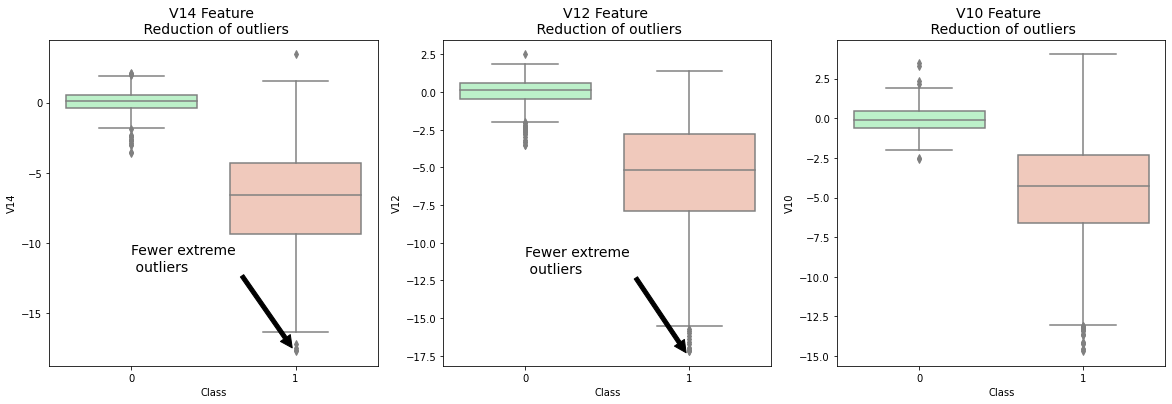

In [21]:
f,(ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,6))

colors = ['#B3F9C5', '#f9c5b3']
# 通过绘制箱型图，对比清除异常值之前的箱型图，可以发现，V14\V12\V10 三个特征值的极端异常值被清除了。

# 1、Feature V14
sns.boxplot(x="Class", y="V14", data=new_df,ax=ax1, palette=colors)
ax1.set_title("V14 Feature \n Reduction of outliers", fontsize=14)
ax1.annotate('Fewer extreme \n outliers', xy=(0.98, -17.5), xytext=(0, -12),
            arrowprops=dict(facecolor='black'),
            fontsize=14)

# 2、Feature 12
sns.boxplot(x="Class", y="V12", data=new_df, ax=ax2, palette=colors)
ax2.set_title("V12 Feature \n Reduction of outliers", fontsize=14)
ax2.annotate('Fewer extreme \n outliers', xy=(0.98, -17.3), xytext=(0, -12),
            arrowprops=dict(facecolor='black'),
            fontsize=14)

# 3、Feature V10
sns.boxplot(x="Class", y="V10", data=new_df, ax=ax3, palette=colors)
ax3.set_title("V10 Feature \n Reduction of outliers", fontsize=14)
ax3.annotate('Fewer extreme \n outliers', xy=(0.95, -16.5), xytext=(0, -12),
             arrowprops=dict(facecolor='black'),
             fontsize=14)

plt.show()

# 9. 降维和聚类（验证算法有效性）

## 9.1 了解 t-SNE算法

- 要了解这个算法必须了解下列术语。
    - 欧氏距离
    - 条件概率
    - 正态分布和T分布
- t-SNE数据可视化算法的作用
    - 通过视觉直观验证算法有效性，或者说是算法评估。
- 摘要
    - 在我们的数据集中，t-SNE算法可以非常准确地聚类出欺诈和非欺诈的案例。
    - 虽然子样本非常小，但是t-SNE算法能够在每个场景中非常准确地检测集群(在运行t-SNE之前，我对数据集进行了打乱)。
    - 这表明，进一步的预测模型将在区分欺诈案例和非欺诈案例方面表现得相当好。

## 9.2 使用TSNE、PCA、SVD进行降维

In [22]:
new_df.shape

(946, 31)

In [23]:
# 定义特征和标签，new_df是直接进行欠采样(不是用算法)后的子数据集
X = new_df.drop('Class', axis = 1)
y = new_df['Class']

# T-SNE算法
t0 = time.time()
X_reduced_tsne = TSNE(n_components=2, random_state=42).fit_transform(X.values)
t1 = time.time()
print("T-SNE took {:.2} s".format(t1 - t0))

# PCA算法
t0 = time.time()
X_reduced_pca = PCA(n_components=2, random_state=42).fit_transform(X.values)
t1 = time.time()
print("PCA took {:.2} s".format(t1 - t0))

# TruncatedSVD（截断奇异值分解算法）
t0 = time.time()
X_reduced_svd = TruncatedSVD(n_components=2, algorithm='randomized', random_state=42).fit_transform(X.values)
t1 = time.time()
print("Truncated SVD took {:.2} s".format(t1 - t0))

T-SNE took 8.7 s
PCA took 0.019 s
Truncated SVD took 0.007 s


## 9.3 对降维结果进行可视化

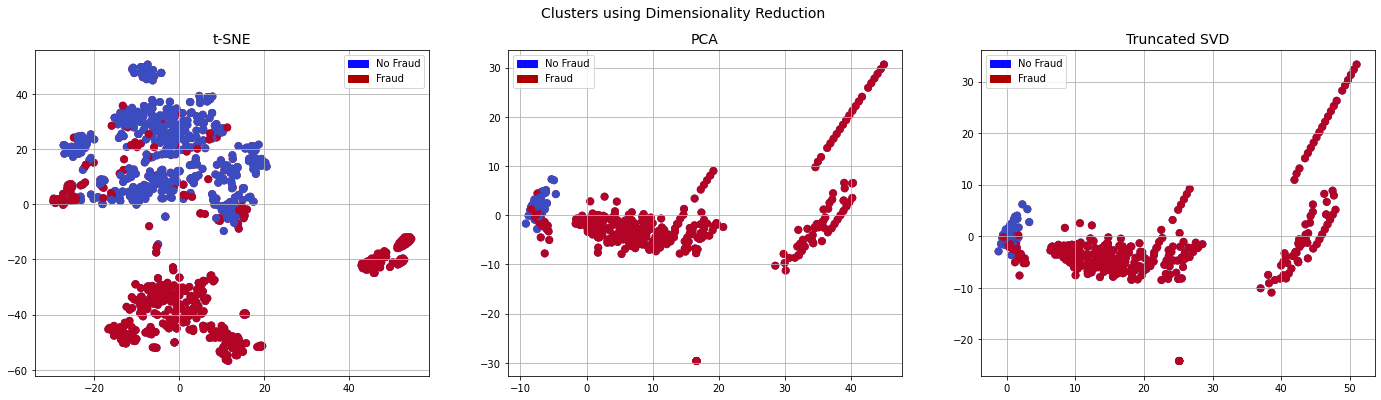

In [24]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24,6))

f.suptitle('Clusters using Dimensionality Reduction', fontsize=14)

# 设定欺诈交易点和非欺诈交易点的颜色
blue_patch = mpatches.Patch(color='#0A0AFF', label='No Fraud')
red_patch = mpatches.Patch(color='#AF0000', label='Fraud')


# t-SNE散点图,c是颜色序列
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax1.set_title('t-SNE', fontsize=14)

ax1.grid(True)

ax1.legend(handles=[blue_patch, red_patch])


# PCA scatter plot
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax2.set_title('PCA', fontsize=14)

ax2.grid(True)

ax2.legend(handles=[blue_patch, red_patch])

# TruncatedSVD scatter plot
ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax3.set_title('Truncated SVD', fontsize=14)

ax3.grid(True)

ax3.legend(handles=[blue_patch, red_patch])

plt.show()

# 10. 欠采样下的分类（NearMiss算法）

- 在本节中，我们将训练四种类型的分类器，并查看哪种分类器在检测欺诈交易时更有效。
在训练模型之前我们必须把数据分为训练集和测试集并且把特征和标签进行分离。

- 摘要
    - 在大多数情况下，LogisticRegression分类器比其他三种分类器更准确。(我们将进一步分析LogisticRegression)
    - GridSearchCV用于确定为分类器提供最佳预测得分的参数。
    - LogisticRegression具有最佳的接收操作特征得分(ROC)，这意味着LogisticRegression能够很准确地区分欺诈和非欺诈交易。
- 学习曲线
    - 训练分数和交叉验证分数之间的差距越大，模型越可能过拟合(高方差)。
    - 如果训练集和交叉验证集的得分都很低，这表明模型欠拟合(高偏差)。
    - 逻辑回归分类器在训练集和交叉验证集上都有最好的表现。

In [25]:
# 在交叉验证之前进行欠采样(容易导致过拟合)
X = new_df.drop('Class', axis=1)
y = new_df['Class']

- 划分训练集和测试集

In [26]:
# 数据已经进行了缩放，我们应该把训练集和测试集分开
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [27]:
# 转化为 array类型，用于建模
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

In [28]:
classifiers = {
    "LogisiticRegression": LogisticRegression(),
    "KNearest": KNeighborsClassifier(),
    "Support Vector Classifier": SVC(),
    "DecisionTreeClassifier": DecisionTreeClassifier()
}

- 开始进行简单的分类。

In [29]:
# 训练集分数
for key, classifier in classifiers.items():
    classifier.fit(X_train, y_train)
    # 当CV是整数时，cross_val_score默认使用KFold或StratifiedKFold策略，后者会在估计器派生ClassifierMixin时使用。
    # 参数cv代表分成几折，其中cv-1折用于训练，1折用于测试
    training_score = cross_val_score(classifier, X_train, y_train, cv=5)
    print("Classifiers: ", classifier.__class__.__name__, "Has a training score of ", round(training_score.mean(), 2) * 100, "% accuracy score")

Classifiers:  LogisticRegression Has a training score of  94.0 % accuracy score
Classifiers:  KNeighborsClassifier Has a training score of  92.0 % accuracy score
Classifiers:  SVC Has a training score of  94.0 % accuracy score
Classifiers:  DecisionTreeClassifier Has a training score of  90.0 % accuracy score


- 使用 GridSearch 来寻找最优参数。

In [30]:
# 使用 GridSearchCV 去查找最优参数
# 1、逻辑回归
log_reg_params = {
    "penalty" : ['l1', 'l2'],
    'C' : [0.001, 0.01, 0.1, 1, 10, 100, 1000]
}

grid_log_reg = GridSearchCV(LogisticRegression(), log_reg_params)
grid_log_reg.fit(X_train, y_train)
# 逻辑回归得到最优模型
log_reg = grid_log_reg.best_estimator_


# 2、KNN
knears_params = {
    "n_neighbors": list(range(2,5,1)),
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}
grid_knears = GridSearchCV(KNeighborsClassifier(), knears_params)
grid_knears.fit(X_train, y_train)
# KNN最优模型
knears_neighbors = grid_knears.best_estimator_

# 3、支持向量机
svc_params = {'C': [0.5, 0.7, 0.9, 1], 'kernel': ['rbf', 'poly', 'sigmoid', 'linear']}
grid_svc = GridSearchCV(SVC(), svc_params)
grid_svc.fit(X_train, y_train)

# SVC最优模型
svc = grid_svc.best_estimator_

# 4、决策树
tree_params = {"criterion": ["gini", "entropy"], "max_depth": list(range(2,4,1)),
              "min_samples_leaf": list(range(5,7,1))}
grid_tree = GridSearchCV(DecisionTreeClassifier(), tree_params)
grid_tree.fit(X_train, y_train)

# 决策树最优模型
tree_clf = grid_tree.best_estimator_

- 因为欠采样是在交叉验证之前进行的，所以这是一个模型过拟合的例子。

In [31]:
# #过拟合的例子，因为欠采样是在交叉验证之前进行的，所以这其实是一个过拟合的例子
log_reg_score = cross_val_score(log_reg, X_train, y_train, cv=5)
print('Logistic Regression Cross Validation Score: ', round(log_reg_score.mean() * 100, 2).astype(str) + '%')


knears_score = cross_val_score(knears_neighbors, X_train, y_train, cv=5)
print('Knears Neighbors Cross Validation Score', round(knears_score.mean() * 100, 2).astype(str) + '%')

svc_score = cross_val_score(svc, X_train, y_train, cv=5)
print('Support Vector Classifier Cross Validation Score', round(svc_score.mean() * 100, 2).astype(str) + '%')

tree_score = cross_val_score(tree_clf, X_train, y_train, cv=5)
print('DecisionTree Classifier Cross Validation Score', round(tree_score.mean() * 100, 2).astype(str) + '%')

Logistic Regression Cross Validation Score:  94.32%
Knears Neighbors Cross Validation Score 92.46%
Support Vector Classifier Cross Validation Score 93.92%
DecisionTree Classifier Cross Validation Score 92.46%


- 在交叉验证期间进行过采样

- 我们将在交叉验证期间进行欠采样(这里是用NearMiss算法进行的欠采样)

主要是基于Near-Miss算法来实现欠采样：
- Near-miss-1：选择到最近的三个样本平均距离最小的多数类样本
- Near-miss-2：选择到最远的三个样本平均距离最小的多数类样本
- Near-miss-3：为每个少数类样本选择给定数目的最近多数类样本
- 最远距离：选择到最近的三个样本平均距离最大的多样类样本

In [32]:
# 我们将在交叉验证期间进行欠采样(这里是用NearMiss算法进行的欠采样)

undersample_X = df.drop('Class', axis=1)
undersample_y = df['Class']

for train_index, test_index in sss.split(undersample_X, undersample_y):
    print("Train:", train_index, "Test:", test_index)
    undersample_Xtrain, undersample_Xtest = undersample_X.iloc[train_index], undersample_X.iloc[test_index]
    undersample_ytrain, undersample_ytest = undersample_y.iloc[train_index], undersample_y.iloc[test_index]

undersample_Xtrain = undersample_Xtrain.values
undersample_Xtest = undersample_Xtest.values
undersample_ytrain = undersample_ytrain.values
undersample_ytest = undersample_ytest.values

undersample_accuracy = []
undersample_precision = []
undersample_recall = []
undersample_f1 = []
undersample_auc = []

Train: [ 53190  53713  54133 ... 284804 284805 284806] Test: [    0     1     2 ... 56968 56969 56970]
Train: [     0      1      2 ... 284804 284805 284806] Test: [ 53190  53713  54133 ... 117549 118132 118661]
Train: [     0      1      2 ... 284804 284805 284806] Test: [113913 113914 113915 ... 174780 176891 176894]
Train: [     0      1      2 ... 284804 284805 284806] Test: [170874 170875 170876 ... 227847 227848 227849]
Train: [     0      1      2 ... 227847 227848 227849] Test: [225900 226455 227289 ... 284804 284805 284806]


In [33]:
# 使用 NearMiss 算法进行欠采样
# 只是查看变量分布，不会使用他们进行模型训练
X_nearmiss, y_nearmiss = NearMiss().fit_resample(undersample_X.values, undersample_y.values)
print('NearMiss Label Distribution: {}'.format(Counter(y_nearmiss)))

NearMiss Label Distribution: Counter({0: 492, 1: 492})


In [34]:

# 正确的操作方式

for train, test in sss.split(undersample_Xtrain, undersample_ytrain):
    # train, test 代表索引值

    # 使用NeearMiss算法进行数据欠采样发生在交叉验证期间，而不是交叉验证之前！
    # imbalanced_make_pipeline：
        #  1、管道先对(undersample_Xtrain[train], undersample_ytrain[train])进行NearMiss欠采样。（样本分布应该是1:1，总条数在984条左右。）
        #  2、再用欠采样后的值再进行逻辑回归模型训练。
        #  3、进行结果测试时，使用的是原始数据undersample_Xtest（(57570,30)）
        
    undersample_pipeline = imbalanced_make_pipeline(NearMiss(sampling_strategy='majority'), log_reg)
    
    # 对undersample_Xtrain（227846*30）进行5次按样本结果平均划分：
        # 1、每次划分时，先用80%的数据（182277*30）使用NearMiss算法，构建平衡数据集（（984*30）：492条欺诈样本、492条正常样本）。
        # 2、再用平衡数据集进行模型训练，得到undersample_model。
        # 3、最后，使用模型对20%测试集（45569*30）进行结果预测。
    undersample_model = undersample_pipeline.fit(undersample_Xtrain[train], undersample_ytrain[train])

    # 使用测试集（原始数据集）进行预测
    undersample_prediction = undersample_model.predict(undersample_Xtrain[test])

    # 分数计算并存储到list之中，每个list保存5个结果
    undersample_accuracy.append(undersample_pipeline.score(original_Xtrain[test], original_ytrain[test])) # 准确率
    undersample_precision.append(precision_score(original_ytrain[test], undersample_prediction)) # 精准率
    undersample_recall.append(recall_score(original_ytrain[test], undersample_prediction)) # 召回率
    undersample_f1.append(f1_score(original_ytrain[test], undersample_prediction)) # F1值
    undersample_auc.append(roc_auc_score(original_ytrain[test], undersample_prediction)) #AUC分数

- 将四个分类器的学习曲线画出来。

In [35]:
# 绘制学习曲线

def plot_learning_curve(estimator1, estimator2, estimator3, estimator4, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(20,14), sharey=True)
    if ylim is not None:
        plt.ylim(*ylim)

    # First Estimator
    train_sizes, train_scores, test_scores = learning_curve(
        estimator1, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax1.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax1.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax1.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax1.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax1.set_title("Logistic Regression Learning Curve", fontsize=14)
    ax1.set_xlabel('Training size (m)')
    ax1.set_ylabel('Score')
    ax1.grid(True)
    ax1.legend(loc="best")

    # Second Estimator
    train_sizes, train_scores, test_scores = learning_curve(
        estimator2, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax2.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax2.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax2.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax2.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax2.set_title("Knears Neighbors Learning Curve", fontsize=14)
    ax2.set_xlabel('Training size (m)')
    ax2.set_ylabel('Score')
    ax2.grid(True)
    ax2.legend(loc="best")

    # Third Estimator
    train_sizes, train_scores, test_scores = learning_curve(
        estimator3, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax3.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax3.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax3.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax3.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax3.set_title("Support Vector Classifier \n Learning Curve", fontsize=14)
    ax3.set_xlabel('Training size (m)')
    ax3.set_ylabel('Score')
    ax3.grid(True)
    ax3.legend(loc="best")

    # Fourth Estimator
    train_sizes, train_scores, test_scores = learning_curve(
        estimator4, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax4.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax4.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax4.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax4.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax4.set_title("Decision Tree Classifier \n Learning Curve", fontsize=14)
    ax4.set_xlabel('Training size (m)')
    ax4.set_ylabel('Score')
    ax4.grid(True)
    ax4.legend(loc="best")
    return plt

<module 'matplotlib.pyplot' from 'D:\\SoftWares\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

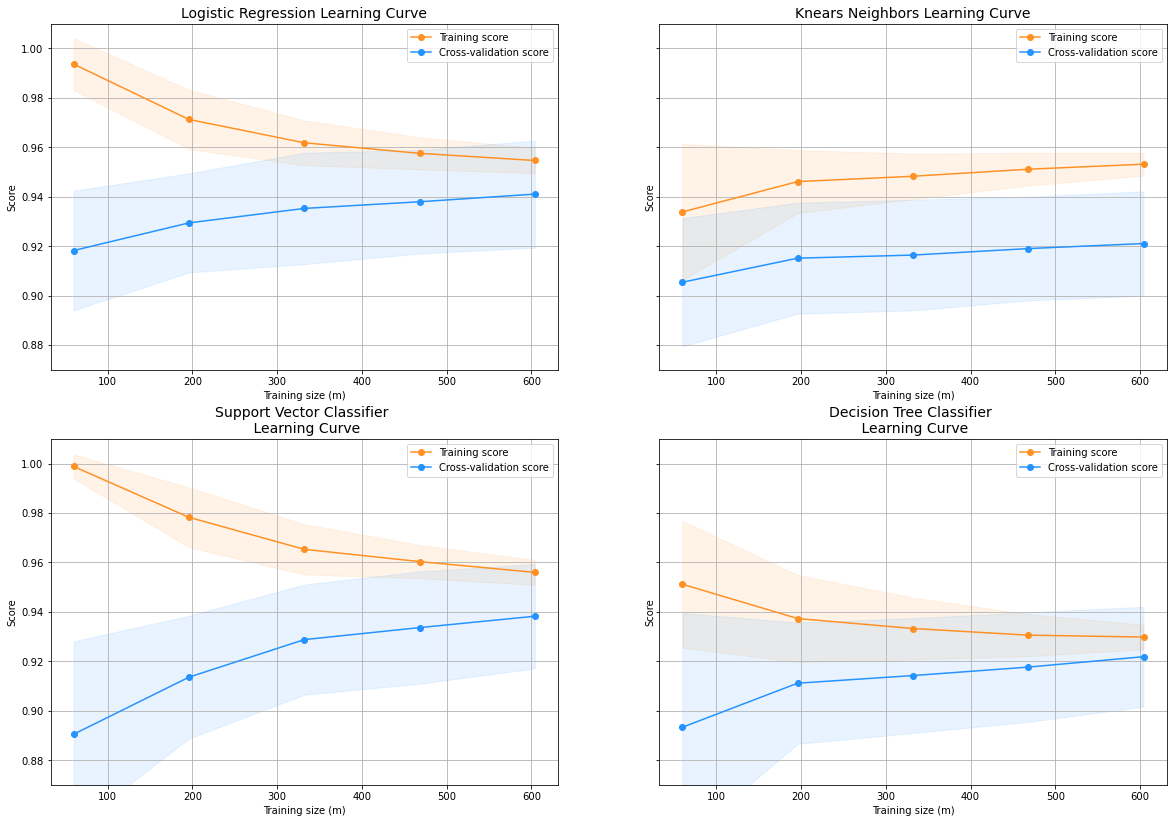

In [36]:
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=42)
plot_learning_curve(log_reg, knears_neighbors, svc, tree_clf, X_train, y_train, (0.87, 1.01), cv=cv, n_jobs=4)

- 将四个分类器的ROC曲线画出来

In [37]:
# Create a DataFrame with all the scores and the classifiers names.
# #cross_val_predict 返回的是estimator的分类结果(或回归值)

log_reg_pred = cross_val_predict(log_reg, X_train, y_train, cv=5,
                             method="decision_function")

knears_pred = cross_val_predict(knears_neighbors, X_train, y_train, cv=5)

svc_pred = cross_val_predict(svc, X_train, y_train, cv=5,
                             method="decision_function")

tree_pred = cross_val_predict(tree_clf, X_train, y_train, cv=5)

In [38]:
print('Logistic Regression: ', roc_auc_score(y_train, log_reg_pred))
print('KNears Neighbors: ', roc_auc_score(y_train, knears_pred))
print('Support Vector Classifier: ', roc_auc_score(y_train, svc_pred))
print('Decision Tree Classifier: ', roc_auc_score(y_train, tree_pred))

Logistic Regression:  0.972467477821803
KNears Neighbors:  0.922125600476875
Support Vector Classifier:  0.9709106209895157
Decision Tree Classifier:  0.9224832567761843


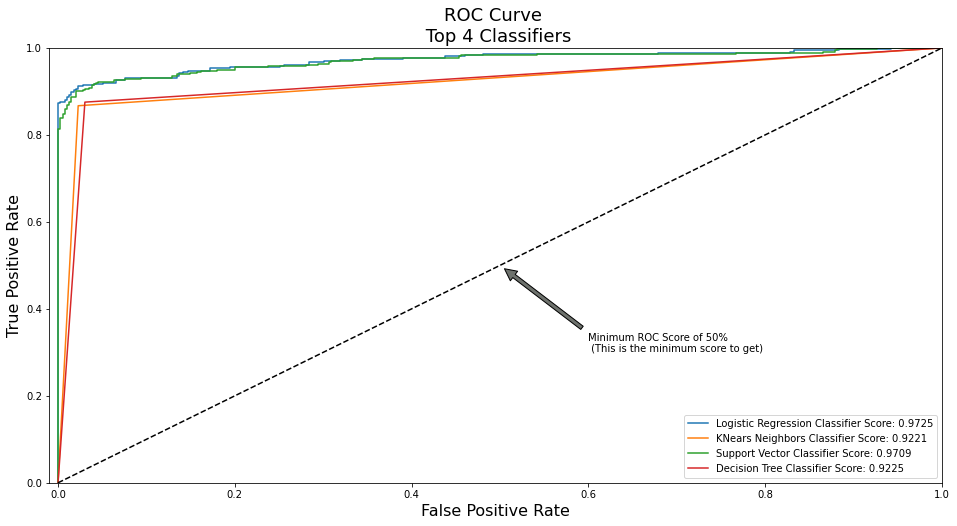

In [39]:
# 画出4个分类器的ROC曲线
log_fpr, log_tpr, log_thresold = roc_curve(y_train, log_reg_pred)
knear_fpr, knear_tpr, knear_threshold = roc_curve(y_train, knears_pred)
svc_fpr, svc_tpr, svc_threshold = roc_curve(y_train, svc_pred)
tree_fpr, tree_tpr, tree_threshold = roc_curve(y_train, tree_pred)


def graph_roc_curve_multiple(log_fpr, log_tpr, knear_fpr, knear_tpr, svc_fpr, svc_tpr, tree_fpr, tree_tpr):
    plt.figure(figsize=(16,8))
    plt.title('ROC Curve \n Top 4 Classifiers', fontsize=18)
    plt.plot(log_fpr, log_tpr, label='Logistic Regression Classifier Score: {:.4f}'.format(roc_auc_score(y_train, log_reg_pred)))
    plt.plot(knear_fpr, knear_tpr, label='KNears Neighbors Classifier Score: {:.4f}'.format(roc_auc_score(y_train, knears_pred)))
    plt.plot(svc_fpr, svc_tpr, label='Support Vector Classifier Score: {:.4f}'.format(roc_auc_score(y_train, svc_pred)))
    plt.plot(tree_fpr, tree_tpr, label='Decision Tree Classifier Score: {:.4f}'.format(roc_auc_score(y_train, tree_pred)))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.01, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.annotate('Minimum ROC Score of 50% \n (This is the minimum score to get)', xy=(0.5, 0.5), xytext=(0.6, 0.3),
                arrowprops=dict(facecolor='#6E726D', shrink=0.05),
                )
    plt.legend()

graph_roc_curve_multiple(log_fpr, log_tpr, knear_fpr, knear_tpr, svc_fpr, svc_tpr, tree_fpr, tree_tpr)
plt.show()

# 11. 深入研究逻辑回归
- 因为在四个分类器中逻辑回归的表现最好，所以在这一节会深入研究逻辑回归分类器
- Terms(一般我们对哪一类比较感兴趣，就把哪一类分为正类，所以这里是把欺诈交易分为正类)
- True Positive 模型预测为正类，实际也是正类
- False Positive 模型预测为正类，实际上不是
- True Negative 模型预测为负类，实际上也是负类
- False Negative 模型预测为负类，实际上是正类


精准率Precision
- 是针对预测结果而言的 所有预测为正的样本中实际为正的样本 Precision=TP/(TP+FP)

召回率Recall
- 是针对实际样本而言的 所有实际为正的样本中被预测为正的样本 Recall=TP/(TP+FN)

顾名思义，精确度Precision表示我们的模型在检测欺诈交易方面有多精确(有多确定)，而召回率recall表示我们的模型能够检测到的欺诈案件数量。

Precision/Recall Tradeoff
- 精确率和召回率之间的权衡
我们的模型越精确(精确率越高)，它能检测到的病例就越少。例子:假设我们的模型的精确度为95%，假设只有5个欺诈案例，其中模型的精确度达到95%或更高，这些都是欺诈案例。
- 假设还有5个案例，我们的模型认为90%是欺诈案例，如果我们降低精确度，我们的模型就能发现更多的案例。


摘要
- 精确度开始下降，在0.90到0.92之间，尽管如此，我们的精确度得分仍然很高，我们的召回率得分仍然下降。

- 画出逻辑回归的ROC曲线

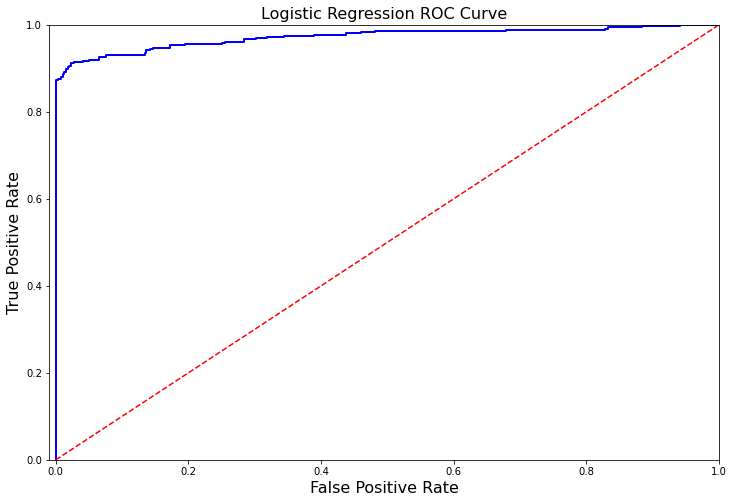

In [40]:
def logistic_roc_curve(log_fpr, log_tpr):
    plt.figure(figsize=(12,8))
    plt.title('Logistic Regression ROC Curve', fontsize=16)
    plt.plot(log_fpr, log_tpr, 'b-', linewidth=2)
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.axis([-0.01,1,0,1])


logistic_roc_curve(log_fpr, log_tpr)
plt.show()

- 画出PR曲线

In [41]:
# 计算精准率，召回率和阈值
precision, recall, threshold = precision_recall_curve(y_train, log_reg_pred)

In [42]:
y_pred = log_reg.predict(X_train)

# 过拟合的例子：对X_train训练，结果有误。
print('---' * 45)
print('Overfitting: \n')
print('Recall Score: {:.2f}'.format(recall_score(y_train, y_pred)))
print('Precision Score: {:.2f}'.format(precision_score(y_train, y_pred)))
print('F1 Score: {:.2f}'.format(f1_score(y_train, y_pred)))
print('Accuracy Score: {:.2f}'.format(accuracy_score(y_train, y_pred)))
print('---' * 45)

# 实际上应该是怎样的
print('---' * 45)
print('How it should be:\n')
print("Accuracy Score: {:.2f}".format(np.mean(undersample_accuracy)))
print("Precision Score: {:.2f}".format(np.mean(undersample_precision)))
print("Recall Score: {:.2f}".format(np.mean(undersample_recall)))
print("F1 Score: {:.2f}".format(np.mean(undersample_f1)))
print('---' * 45)

---------------------------------------------------------------------------------------------------------------------------------------
Overfitting: 

Recall Score: 0.94
Precision Score: 0.69
F1 Score: 0.80
Accuracy Score: 0.77
---------------------------------------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------------------------------------
How it should be:

Accuracy Score: 0.59
Precision Score: 0.00
Recall Score: 0.41
F1 Score: 0.00
---------------------------------------------------------------------------------------------------------------------------------------


In [43]:
undersample_y_score = log_reg.decision_function(original_Xtest)

In [44]:
# #average_precision_score求得的就是average precision_recall score
undersample_average_precision = average_precision_score(original_ytest, undersample_y_score)

print('Average precision-recall score: {0:0.2f}'.format(
      undersample_average_precision))

Average precision-recall score: 0.02


Text(0.5, 1.0, 'UnderSampling Precision-Recall curve: \n Average Precision-Recall Score =0.02')

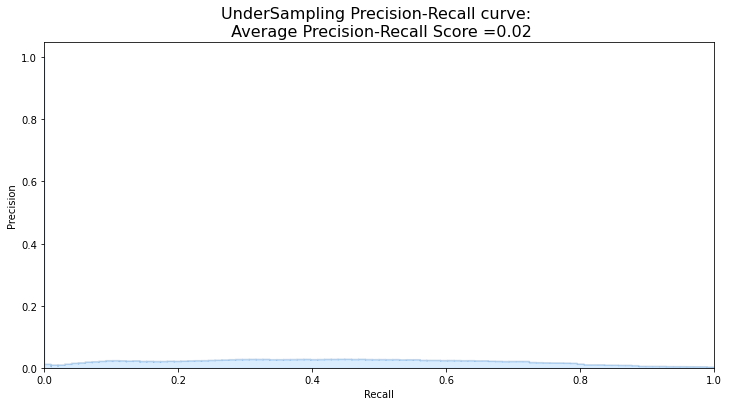

In [45]:
fig = plt.figure(figsize=(12,6))

precision, recall, _ = precision_recall_curve(original_ytest, undersample_y_score)

plt.step(recall, precision, color='#004a93', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='#48a6ff')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('UnderSampling Precision-Recall curve: \n Average Precision-Recall Score ={0:0.2f}'.format(
          undersample_average_precision), fontsize=16)

# 12. 使用 SMOTE 算法进行过采样

- SMOTE算法代表少数合成的过采样技术。和欠采样不同的是，SMOTE创造新的合成的点为了能够得到相等数量的类。这是解决类别不平衡的另一种选择。

## 12.1 了解 SMOTE算法
- Solving the Class imbalance:SMOTE算法从少数类中创造了新的合成点，为了能够和多数类达到一个数量上的平衡。
- 合成点的位置：SMOTE选择少数类与最近邻点之间的距离，在这些距离之间创建合成点。
- Final Effect:由于我们不需要像随机欠采样那样删除任何行，所以保留了更多的信息。
- Accuracy||Time Tradeoff:虽然SMOTE可能会比随机欠采样更加准确，但是像前面所说的那样没有删除任何行，会花更多时间在训练上。

## 12.2 在交叉验证之前进行的过采样或欠采样之所以会导致过拟合的原因

- Overfitting during Cross Validation
    - 在我们的过采样分析中，我想和大家分享一个我所犯的常见错误。这很简单，如果您想对数据进行过采样或欠采样，在交叉验证之前不应该这样做。
    - 因为在实现交叉验证之前进行过采样或欠采样，您将直接影响验证集，从而导致“数据泄漏”问题。在下一节中，您将看到惊人的精确率和召回率分数，但实际上我们的数据是过拟合!
- 错误的例子：见图
- 就像之前说的那样，如果我们在我们的数据集中获得了少数类(“Fraud”)，并且在交叉验证之前创建了合成点，那么我们就会对交叉验证过程的“验证集”产生一定的影响。
- 原始数据集经过过采样之后合成了新的数据集，这时候再进行交叉验证的话划分为训练集的一部分数据会是验证集的数据所合成的，这样就会导致数据泄漏。
- 因此，我们必须在交叉验证期间而不是在交叉验证之前创建合成数据点，如下所示: 见图

- 正如上图所看到的那样，SMOTE发生在交叉验证期间，而不是在交叉验证之前。
- 原始数据集先通过交叉验证划分为训练集和验证集，然后SMOTE只应用于训练集的数据，从而产生新的合成点，而验证集部分数据并没有变化，这样就不会导致数据泄漏。

- 运用SMOTE进行过采样

In [46]:
print('Length of X (train): {} | Length of y (train): {}'.format(len(original_Xtrain), len(original_ytrain)))
print('Length of X (test): {} | Length of y (test): {}'.format(len(original_Xtest), len(original_ytest)))

# 用于存储分数，计算平均值
accuracy_lst = []
precision_lst = []
recall_lst = []
f1_lst = []
auc_lst = []

# 默认参数下的逻辑回归器
log_reg_sm = LogisticRegression()

# RandomizedSearchCV（随机搜索）可以快速地帮助我们确定一个参数的大概范围，然后我们再使用网格搜索确定参数的精确值。
# 就像警察抓犯人一样，先得快速地确认罪犯的活动区域，然后在该区域内展开地毯式搜索，这样效率更高。
# n_iter：随机寻找参数组合的数量，默认值为10。
rand_log_reg = RandomizedSearchCV(LogisticRegression(), log_reg_params, n_iter=4)

# 交叉验证的正确方式
log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

for train, test in sss.split(original_Xtrain, original_ytrain):
    # SMOTE 算法用在交叉验证期间，而不是交叉验证之前
    # 定义管道，先对original_Xtrain（227846*30）的80%的数据进行SMOTE处理，再进行RandomizedSearchCV（随机搜索）
    pipeline = imbalanced_make_pipeline(SMOTE(sampling_strategy='minority'), rand_log_reg)
    # 使用SMOTE处理后的翻倍数据进行模型训练
    model = pipeline.fit(original_Xtrain[train], original_ytrain[train])
    # 搜索出最佳模型
    best_est = rand_log_reg.best_estimator_
    
    # 使用最佳模型对original_Xtrain（227846*30）的20%的数据进行测试
    prediction = best_est.predict(original_Xtrain[test])

    # 存储测试数据
    accuracy_lst.append(pipeline.score(original_Xtrain[test], original_ytrain[test]))
    precision_lst.append(precision_score(original_ytrain[test], prediction))
    recall_lst.append(recall_score(original_ytrain[test], prediction))
    f1_lst.append(f1_score(original_ytrain[test], prediction))
    auc_lst.append(roc_auc_score(original_ytrain[test], prediction))

print('---' * 45)
print('')
print("accuracy: {}".format(np.mean(accuracy_lst)))
print("precision: {}".format(np.mean(precision_lst)))
print("recall: {}".format(np.mean(recall_lst)))
print("f1: {}".format(np.mean(f1_lst)))
print('---' * 45)

Length of X (train): 227846 | Length of y (train): 227846
Length of X (test): 56961 | Length of y (test): 56961
---------------------------------------------------------------------------------------------------------------------------------------

accuracy: 0.9491767417332426
precision: 0.0614719751144963
recall: 0.9162934112301201
f1: 0.11357365636546764
---------------------------------------------------------------------------------------------------------------------------------------


- 查看模型分类能力

In [56]:
# #classification_report()用于显示主要分类指标的文本报告

labels = ['No Fraud', 'Fraud']

# 对原始的测试集数据进行验证
smote_prediction = best_est.predict(original_Xtest)
print(classification_report(original_ytest, smote_prediction, target_names=labels))

              precision    recall  f1-score   support

    No Fraud       1.00      0.99      0.99     56863
       Fraud       0.10      0.86      0.18        98

    accuracy                           0.99     56961
   macro avg       0.55      0.92      0.58     56961
weighted avg       1.00      0.99      0.99     56961

[[56088   775]
 [   14    84]]


In [48]:
y_score = best_est.decision_function(original_Xtest)

In [49]:
# 计算平均精度 average_precision

average_precision = average_precision_score(original_ytest, y_score)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

Average precision-recall score: 0.70


- 画出过采样后的PR曲线

Text(0.5, 1.0, 'OverSampling Precision-Recall curve: \n Average Precision-Recall Score =0.70')

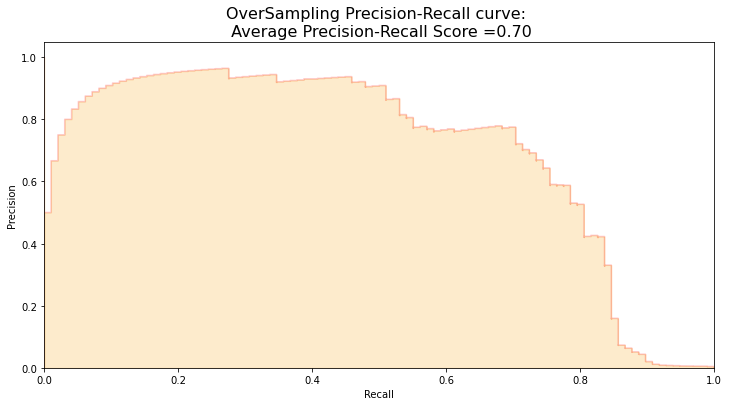

In [50]:
fig = plt.figure(figsize=(12,6))

precision, recall, _ = precision_recall_curve(original_ytest, y_score)

plt.step(recall, precision, color='r', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='#F59B00')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('OverSampling Precision-Recall curve: \n Average Precision-Recall Score ={0:0.2f}'.format(
          average_precision), fontsize=16)

In [51]:
# 分割数据和交叉验证后的SMOTE技术(过采样)

sm = SMOTE(sampling_strategy='minority', random_state=42)

# 这就是我们要用到的数据
Xsm_train, ysm_train = sm.fit_resample(original_Xtrain, original_ytrain)

- 训练过采样数据所花的时间

In [52]:
t0 = time.time()
log_reg_sm = grid_log_reg.best_estimator_
log_reg_sm.fit(Xsm_train, ysm_train)
t1 = time.time()
print("Fitting oversample data took :{} sec".format(t1 - t0))

Fitting oversample data took :3.0006868839263916 sec


# 13. 使用测试集去测试逻辑回归的效果

- 摘要
- Random UnderSamping
    - 我们将评估分类模型在随机欠采样子集中的最终性能。请记住，这不是来自原始dataframe的数据。
- Classification Models
    - 这些模型中表现得最好的是逻辑回归和SVM

## 13.1 用混淆矩阵来评估这些分类器的性能

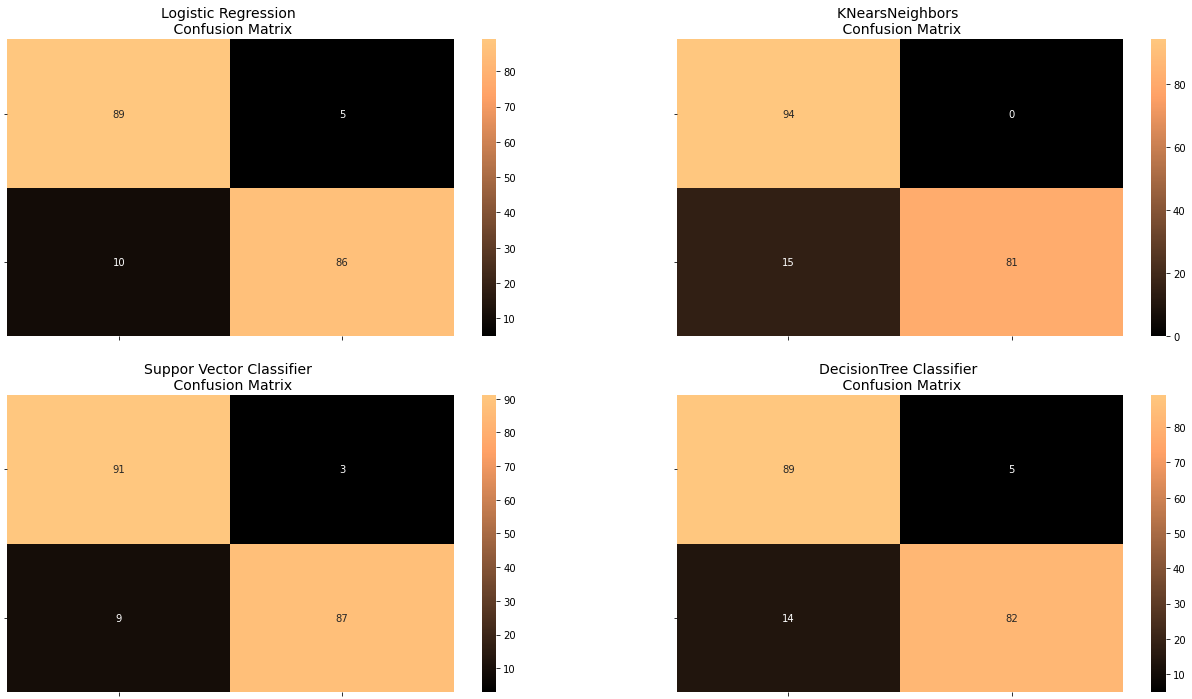

In [53]:
# 使用 SMOTE 技术去训练逻辑回归模型
# X_test (190, 30)
# log_reg_sm 使用过采样后的数据进行了训练（Xsm_train, ysm_train训练而来）
y_pred_log_reg = log_reg_sm.predict(X_test)

# 使用欠采样技术训练其他模型（X_train, y_train训练而来）
y_pred_knear = knears_neighbors.predict(X_test)
y_pred_svc = svc.predict(X_test)
y_pred_tree = tree_clf.predict(X_test)

log_reg_cf = confusion_matrix(y_test, y_pred_log_reg)
kneighbors_cf = confusion_matrix(y_test, y_pred_knear)
svc_cf = confusion_matrix(y_test, y_pred_svc)
tree_cf = confusion_matrix(y_test, y_pred_tree)

fig, ax = plt.subplots(2, 2,figsize=(22,12))


sns.heatmap(log_reg_cf, ax=ax[0][0], annot=True, cmap=plt.cm.copper)
ax[0, 0].set_title("Logistic Regression \n Confusion Matrix", fontsize=14)
ax[0, 0].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[0, 0].set_yticklabels(['', ''], fontsize=14, rotation=360)

sns.heatmap(kneighbors_cf, ax=ax[0][1], annot=True, cmap=plt.cm.copper)
ax[0][1].set_title("KNearsNeighbors \n Confusion Matrix", fontsize=14)
ax[0][1].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[0][1].set_yticklabels(['', ''], fontsize=14, rotation=360)

sns.heatmap(svc_cf, ax=ax[1][0], annot=True, cmap=plt.cm.copper)
ax[1][0].set_title("Suppor Vector Classifier \n Confusion Matrix", fontsize=14)
ax[1][0].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[1][0].set_yticklabels(['', ''], fontsize=14, rotation=360)

sns.heatmap(tree_cf, ax=ax[1][1], annot=True, cmap=plt.cm.copper)
ax[1][1].set_title("DecisionTree Classifier \n Confusion Matrix", fontsize=14)
ax[1][1].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[1][1].set_yticklabels(['', ''], fontsize=14, rotation=360)


plt.show()

In [54]:
print('Logistic Regression:')
print(classification_report(y_test, y_pred_log_reg))

print('KNears Neighbors:')
print(classification_report(y_test, y_pred_knear))

print('Support Vector Classifier:')
print(classification_report(y_test, y_pred_svc))

print('Support Vector Classifier:')
print(classification_report(y_test, y_pred_tree))

Logistic Regression:
              precision    recall  f1-score   support

           0       0.90      0.95      0.92        94
           1       0.95      0.90      0.92        96

    accuracy                           0.92       190
   macro avg       0.92      0.92      0.92       190
weighted avg       0.92      0.92      0.92       190

KNears Neighbors:
              precision    recall  f1-score   support

           0       0.86      1.00      0.93        94
           1       1.00      0.84      0.92        96

    accuracy                           0.92       190
   macro avg       0.93      0.92      0.92       190
weighted avg       0.93      0.92      0.92       190

Support Vector Classifier:
              precision    recall  f1-score   support

           0       0.91      0.97      0.94        94
           1       0.97      0.91      0.94        96

    accuracy                           0.94       190
   macro avg       0.94      0.94      0.94       190
weighted

# 13.2 输出逻辑回归在测试集的分数

In [55]:
# 逻辑回归模型下的最终分数
# 欠采样模型（X_train, y_train 训练而来）

y_pred = log_reg.predict(X_test)
undersample_score = accuracy_score(y_test, y_pred)

# 采用过采样技术的逻辑回归模型（对原始测试集进行预测并评估结果 original_Xtest （56961， 30））
y_pred_sm = best_est.predict(original_Xtest)
oversample_score = accuracy_score(original_ytest, y_pred_sm)

d = {'Technique': ['Random UnderSampling', 'Oversampling (SMOTE)'], 'Score': [undersample_score, oversample_score]}
final_df = pd.DataFrame(data=d)

# 移动分数段
score = final_df['Score']
final_df.drop('Score', axis=1, inplace=True)
final_df.insert(1, 'Score', score)

# Note how high is accuracy score it can be misleading!
final_df

,Technique,Score
0,Random UnderSampling,0.921053
1,Oversampling (SMOTE),0.986148


# 总结

- 不要在交叉验证之前进行过采样或者欠采样，而是应该在交叉验证期间进行，否则会导致过拟合。
- 一般情况下，过采样的效果会比欠采样的效果好，因为欠采样删除了大量的信息，但是过采样会比欠采样所花的时间要多。